5. um


WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable gNa is present in the namespace but is also an internal variable of spatialneuron, the internal variable will be used.


Starting simulation for duration 300. ms
300. ms (100%) simulated in 3s
1.00676783251
5. um


WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable gNa is present in the namespace but is also an internal variable of spatialneuron_1, the internal variable will be used.


Starting simulation for duration 300. ms
300. ms (100%) simulated in 3s
1.00063850673
5. um
Starting simulation for duration 300. ms
300. ms (100%) simulated in 3s
1.00010455403
5. um
Starting simulation for duration 300. ms
300. ms (100%) simulated in 3s
1.00002274782
5. um
Starting simulation for duration 300. ms
300. ms (100%) simulated in 3s
1.00000593424
5. um
Starting simulation for duration 300. ms
300. ms (100%) simulated in 3s
1.00000176106


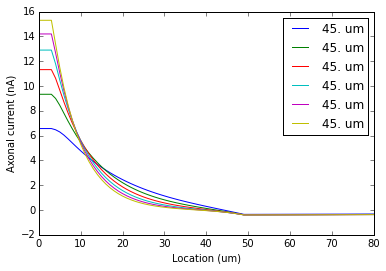

In [1]:
"""
Cylindrical axon model voltage clamped at on

"""



%matplotlib inline

from brian2 import *
import pandas as pd
import gc

defaultclock.dt = 0.015*ms

# Standard parameters
# Passive parameters
EL = -80*mV
Cm = 0.9*uF/cm**2
gL = 1.*(siemens/meter**2)
Ri = 150*ohm*cm

# Na channels
ENa = 60.*mV
ka = 6.*mV
va = -30.*mV
#gNa = 3000.*(siemens/meter**2) 
taum = 0.05*ms

# Morphology
length = 300.*um
diam = 1.5*um

# Na channels
AIS_length = 45.*um
Na_start = 5.*um

# Parameter ranges for loops
#diams = [0.5,1.,1.5,2.,2.5,3.,3.5]*um
#AIS_lengths = [30.,35.,40.,45.,50.,55.,60.]*um
#Na_starts = [0.,5.,10.,15.,20.,25.,30.,35.]*um
gNas = [1000.,2000.,3000.,4000.,5000.,6000.]*(siemens/meter**2) 
#gLs = [0.7,0.8,0.9,1.,1.1,1.2,1.3]*(siemens/meter**2)

thresholds = []
I_thres_preds  = []
I_thres_sims = []
I_above_preds = []
I_above_preds2 = []
I_above_sims = []

for gNa in gNas:
    print Na_start
    Na_end = Na_start+AIS_length
    axon = Cylinder(diameter=diam, length=length, n=300)
    
    duration = 300*ms
    
    # Channels
    eqs='''
    Im = gL*(EL - v) + gclamp*(vc - v) + gNa*m*(ENa - v) : amp/meter**2
    dm/dt = (minf - m) / taum: 1  # simplified Na channel
    minf = 1 / (1 + exp((va - v) / ka)) : 1
    gclamp : siemens/meter**2
    gNa : siemens/meter**2
    vc = EL + 50*mV * t / duration : volt (shared)  # Voltage clamp with a ramping voltage command
    '''

    neuron = SpatialNeuron(morphology=axon, model=eqs, Cm=Cm, Ri=Ri,
                       method="exponential_euler")
    
    # AIS definition
    initial_segment = axon[Na_start:Na_end]
    neuron.gNa[initial_segment] = gNa
    
    # Initialisation
    neuron.v = EL
    neuron.gclamp[0] = gL*5000000

    # Monitors
    mon = StateMonitor(neuron, ('v','m'), record=True)
    
    run(duration, report='text')

    # Theory
    gdensity = (4.*Ri/diam)*gNa             # meter**-2
    ra = (4.*Ri)/(pi*diam**2)               # ohm/cm
    supp = 1./(sqrt(gdensity)*tanh(sqrt(gdensity)*AIS_length))    # The non-physical distance term in V'(0)

    def dv_na_start(y):
        return (ENa-y)*(1./(Na_start+supp))
    def I_peak(y):
        return dv_na_start(y)/ra
    
    # Other formulation of the theory
    alpha = 1./(tanh(sqrt((4.*Ri*gNa)/diam)*AIS_length))
    cste1 = 0.5*sqrt(diam/(gNa*Ri))*alpha
    print alpha

    def I_peak_k(y):
        return ((ENa-y)*((pi*diam**2)/(4*Ri)))/(Na_start+cste1)
    
    dvdx = diff(mon.v,axis=0)/(1*um)
    vs_range1 = linspace(-75, -55, 21)*mV
    x = neuron.distance
    dt_per_volt = len(mon.t) / (50*mV)
    
    for vs in vs_range1:
        # Rough threshold
        thres_approx = [vs for vs in vs_range1 if mon.m[Na_end/um-1, int(dt_per_volt * (vs - EL))] >= 0.5][0]
    
    # Precise threshold
    dv_per_dt  = (50.*mV)/(duration/defaultclock.dt)
    dv_in_1mV = (1.*mV)/dv_per_dt
    vs_range2 = linspace(thres_approx/mV-2., thres_approx/mV+2., 4*dv_in_1mV)*mV
    thres = [vs for vs in vs_range2 if mon.m[Na_end/um-1, int(dt_per_volt * (vs - EL))] >= 0.5][0]
    
    if Na_start==0*um:
        I_thres_sim = (dvdx[Na_start/um,int(dt_per_volt * (thres - EL))]/ra)/namp
        I_above_sim = (dvdx[Na_start/um,int(dt_per_volt * (thres+0.2*mV - EL))]/ra)/namp
    else:
        I_thres_sim = (dvdx[Na_start/um-1,int(dt_per_volt * (thres - EL))]/ra)/namp
        I_above_sim = (dvdx[Na_start/um-1,int(dt_per_volt * (thres+0.2*mV - EL))]/ra)/namp
    
    I_thres_pred = I_peak(thres)/namp
    I_above_pred = I_peak(thres+0.2*mV)/namp
    I_above_pred2 = I_peak_k(thres+0.2*mV)/namp
    
    figure(1)
    plot((dvdx[:,int(dt_per_volt * (thres+0.2*mV - EL))]/ra)/namp, label='%s' %AIS_length)
    xlabel('Location (um)')
    ylabel('Axonal current (nA)')
    legend(loc='best')
    xlim(0,80)
    
    thresholds.append(thres)
    I_thres_preds.append(I_thres_pred)
    I_thres_sims.append(I_thres_sim)
    I_above_preds.append(I_above_pred)
    I_above_preds2.append(I_above_pred2)
    I_above_sims.append(I_above_sim)
    
show()

In [2]:
I_above_sims

[6.470512874842966,
 8.998542492037393,
 10.626796773926278,
 11.788457039664781,
 12.67506617884729,
 13.386850298803791]

In [3]:
I_above_preds2

[6.778751582504581,
 9.094111105968656,
 10.640794496798847,
 11.822091547003247,
 12.782093013565603,
 13.59225608480604]

In [5]:
from openpyxl import load_workbook

dv_start = {'Parameter': gNas/(siemens/meter**2) ,
            'Current (simulation) (nA)':I_above_sims, 
            'Current (prediction) (nA)':I_above_preds}

df_dv_start = pd.DataFrame(dv_start)

book = load_workbook("/Users/sarahgoethals/Dropbox/Project-2_RBrette/Data Fig4/panelC2_gNa.xlsx")
writer = pd.ExcelWriter("/Users/sarahgoethals/Dropbox/Project-2_RBrette/Data Fig4/panelC2_gNa.xlsx", engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

df_dv_start.to_excel(writer, "Na conductance")

writer.save()

Axonal peak current 

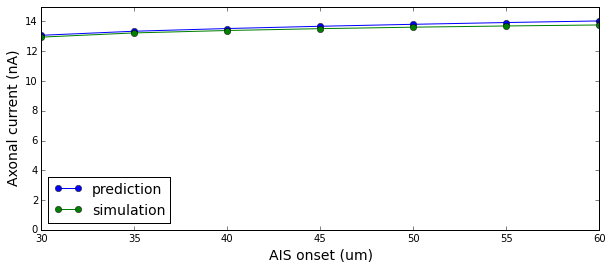

In [6]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 4)

plot(AIS_lengths/um , I_above_preds,  'bo-', label='prediction')
plot(AIS_lengths/um, I_above_sims, 'go-', label='simulation')
xlabel('AIS onset (um)', fontsize=14)
ylabel('Axonal current (nA)', fontsize=14)
legend(loc='best', fontsize=14)
ylim(0,15)
show()

Somatic voltage threshold for spike initiation

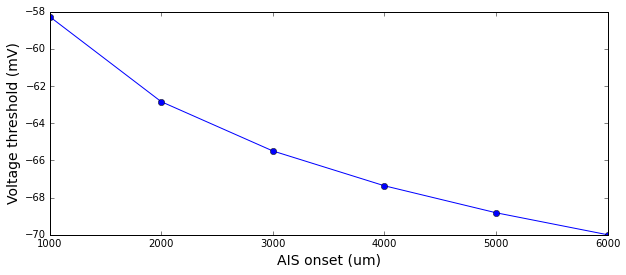

In [19]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 4)

plot(gNas/(siemens/meter**2) ,thresholds/mV,  'bo-')
xlabel('AIS onset (um)', fontsize=14)
ylabel('Voltage threshold (mV)', fontsize=14)
#ylim(-75,-60)
show()